In [98]:
 import sklearn 

In [99]:
from sklearn.datasets import make_circles

X , y = make_circles(n_samples=1000,noise=0.03,random_state=67)

In [100]:
import pandas as pd
circles = pd.DataFrame({"X1": X[ : , 0], "X2": X[:,1] , "label": y})
circles.head(5)

,X1,X2,label
0,0.233230,0.810821,1
1,0.175660,-1.000523,0
2,-0.606525,0.544122,1
3,0.453224,-0.673099,1
4,0.133497,0.836877,1


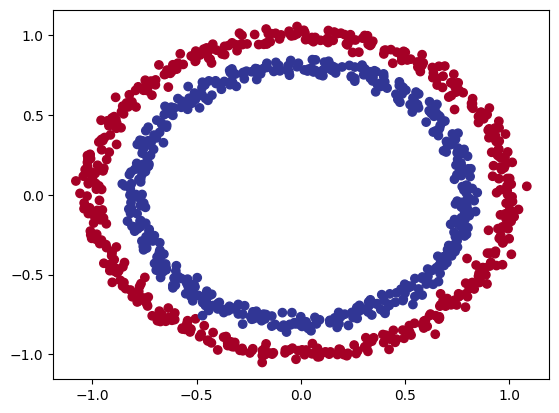

In [101]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0] , y=X[:,1],c=y , cmap=plt.cm.RdYlBu);

In [102]:
import torch
X = torch.from_numpy(X)
y = torch.from_numpy(y)
len(X),len(y)

(1000, 1000)

In [103]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y)

In [104]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [105]:
X_train , X_test , y_train , y_test = X_train.to(device) , X_test.to(device) , y_train.to(device) , y_test.to(device)

In [106]:
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

In [107]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2 , out_features=5)
        self.layer_2 = nn.Linear(in_features=5 , out_features=1)

    def forward(self,x:torch.Tensor):
        assert x.dtype == torch.float32
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)

In [108]:
model_0 = nn.Sequential(nn.Linear(in_features=2,out_features=5) , nn.Linear(in_features=5,out_features=1)).to(device)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2138,  0.0263],
                      [ 0.1883,  0.0429],
                      [-0.3092,  0.2258],
                      [ 0.2110, -0.5847],
                      [-0.1600,  0.2572]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3691,  0.5009,  0.3315,  0.4882,  0.2810], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3172,  0.1063,  0.0332, -0.0218, -0.3968]], device='cuda:0')),
             ('1.bias', tensor([-0.0564], device='cuda:0'))])

In [109]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [110]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [112]:
torch.manual_seed(67)
torch.cuda.manual_seed(42)

epochs = 10000

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} , Acc: {acc} | Test Loss: {test_loss} , Test Acc: {test_acc}")    

Epoch: 0 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 1000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 2000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 3000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 4000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 5000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 6000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 7000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , Test Acc: 50.0
Epoch: 8000 | Loss: 0.6923128366470337 , Acc: 54.266666666666666 | Test Loss: 0.698930561542511 , T

In [114]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Skip")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py" , "wb" ) as f:
        f.write(request.content)

from helper_functions import plot_predictions , plot_decision_boundary

Downloading


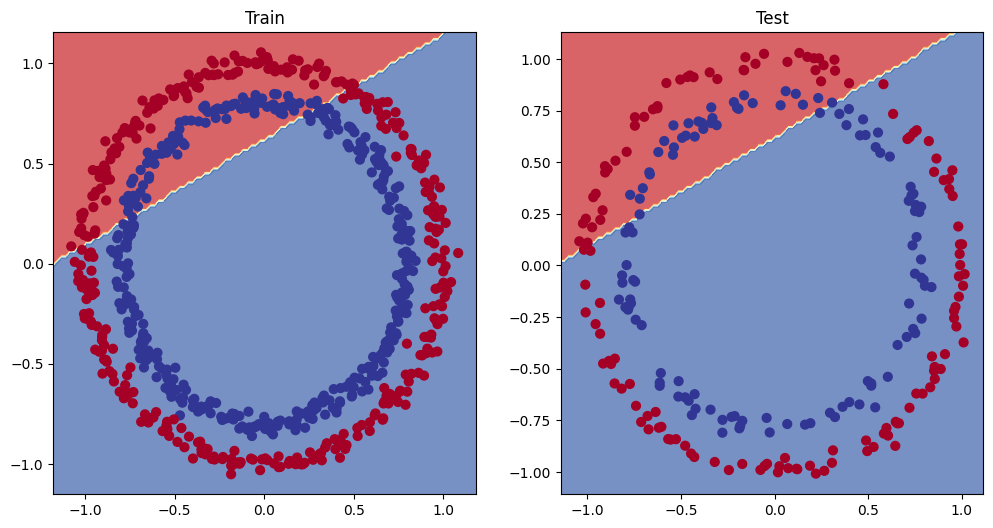

In [117]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0 , X_test , y_test)

In [125]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)

In [126]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [127]:
torch.manual_seed(67)
torch.cuda.manual_seed(67)

epochs = 10000

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} , Acc: {acc} | Test Loss: {test_loss} , Test Acc: {test_acc}")    

Epoch: 0 | Loss: 0.7195900678634644 , Acc: 48.66666666666667 | Test Loss: 0.7002065777778625 , Test Acc: 54.0
Epoch: 1000 | Loss: 0.508755624294281 , Acc: 82.53333333333333 | Test Loss: 0.5332818627357483 , Test Acc: 77.60000000000001
Epoch: 2000 | Loss: 0.027577321976423264 , Acc: 99.86666666666667 | Test Loss: 0.026344887912273407 , Test Acc: 100.0
Epoch: 3000 | Loss: 0.011032943613827229 , Acc: 100.0 | Test Loss: 0.01151304692029953 , Test Acc: 100.0
Epoch: 4000 | Loss: 0.006874687038362026 , Acc: 100.0 | Test Loss: 0.007880941964685917 , Test Acc: 100.0
Epoch: 5000 | Loss: 0.005019606091082096 , Acc: 100.0 | Test Loss: 0.006135421339422464 , Test Acc: 100.0
Epoch: 6000 | Loss: 0.003960167523473501 , Acc: 100.0 | Test Loss: 0.005137340165674686 , Test Acc: 100.0
Epoch: 7000 | Loss: 0.003272339468821883 , Acc: 100.0 | Test Loss: 0.004487940110266209 , Test Acc: 100.0
Epoch: 8000 | Loss: 0.0027890095952898264 , Acc: 100.0 | Test Loss: 0.0040257577784359455 , Test Acc: 100.0
Epoch: 900

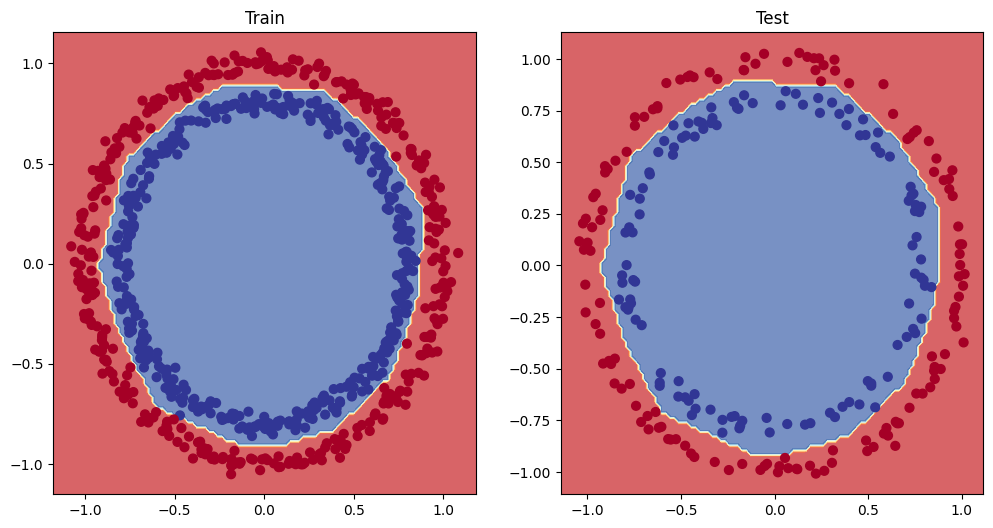

In [128]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1 , X_test , y_test)